In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import scipy.sparse
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import silhouette_score


from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

from ZIFA import ZIFA
from ZINB import ZINB
from SIMLR import SIMLR

from benchmarking import *

In [2]:
data_path = "data/bipolar/"

In [3]:
n_latent = 10

# Importing data

In [4]:
# load clusters from author
clusters = pd.read_csv(data_path + "ClustAssignFile.txt", index_col=0, sep="\t")[["CLUSTER"]]
clusters = clusters[clusters.CLUSTER <= 15]

# load batch info from online
batch_id = pd.read_csv(data_path + "batch_id.csv", index_col=0)
encoder = OneHotEncoder()
batch = encoder.fit_transform(batch_id)
batch_id = batch_id.values[:, 0]

# load barcodes, combat and expression data from online
barcodes = [x[0] for x in pd.read_csv(data_path + "barcodes.csv", index_col=0).values.astype(np.str)]
expression = scipy.io.mmread(data_path + "count.mtx").T.A
pca_combat = pd.read_csv(data_path + "pca_combat.csv", index_col=0)

# slice to only cells from identified cell_types
expression = pd.DataFrame(data = expression, index=barcodes).loc[clusters.index]
batch_id = pd.DataFrame(data = batch_id, index=barcodes).loc[clusters.index]
pca_combat = pd.DataFrame(data = pca_combat, index=barcodes).loc[clusters.index]
clusters = np.array([x[0] for x in clusters.values])
print expression.shape , pca_combat.shape, batch.shape, clusters.shape

(26439, 13166) (26439, 100) (27499, 2) (26439,)


In [5]:
np.unique(clusters)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [6]:
expression_train, expression_test, combat_train, combat_test, b_train, b_test, c_train, c_test = \
                train_test_split(expression.as_matrix(), pca_combat.as_matrix(), batch_id.as_matrix(), \
                                 clusters, random_state=0)

In [43]:
scipy.sparse.save_npz(data_path + "data_train.npz", scipy.sparse.coo_matrix(expression_train))
scipy.sparse.save_npz(data_path + "data_test.npz", scipy.sparse.coo_matrix(expression_test))

np.savetxt(data_path + "batch_train", b_train)
np.savetxt(data_path + "batch_test", b_test)

np.savetxt(data_path + "combat_train", combat_train)
np.savetxt(data_path + "combat_test", combat_test)

np.savetxt(data_path + "c_train", c_train)
np.savetxt(data_path + "c_test", c_test)

# Now benchmarking

In [17]:
from sklearn.manifold import TSNE
def show_tSNE(latent, name, tSNE=True, labels=None, cmap=plt.get_cmap("tab20", 15)):
    
    if labels is None:
        labels = c_train
    if tSNE:
        tsne = TSNE().fit_transform(latent)
        
    else:
        tsne = latent
    plt.figure(figsize=(10, 10))
    plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, \
                                   cmap=cmap, edgecolors='none')
    plt.axis("off")
    plt.title("tSNE for latent space " + name, fontsize=16)
    return tsne

In [8]:
proj_combat = PCA(n_components=n_latent).fit_transform(combat_train)
print cluster_scores(proj_combat, len(np.unique(c_train)), c_train)
print entropy_batch_mixing(proj_combat, b_train)
print silhouette_score(proj_combat, b_train)

[0.44694698300835106, 0.794144880698191, 0.47583467153476738]
0.34069311837


/home/romain/tensorflow/local/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.019781812657


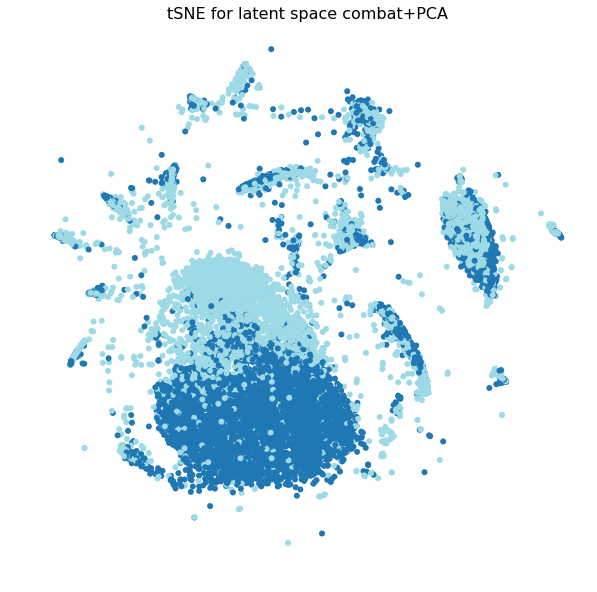

In [13]:
proj_combat = PCA(n_components=100).fit_transform(combat_train)
tsne_combat = show_tSNE(proj_combat, "combat+PCA", labels=b_train)

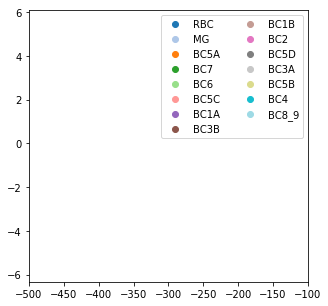

In [57]:
# Now have the legends
plt.figure(figsize=(5, 5))

cmap = plt.get_cmap("tab20", 15)
label = ["RBC","MG","BC5A","BC7","BC6","BC5C","BC1A","BC3B","BC1B","BC2","BC5D","BC3A","BC5B","BC4","BC8_9"]
for t in np.unique(c_train):
    plt.scatter(tsne_combat[c_train == t, 0], tsne_combat[c_train == t, 1], c=cmap((t-1) / 15.), label=label[t-1])
plt.xlim((-500, -100))
plt.legend(ncol=2)
plt.savefig("bipolar_legend_celltypes.pdf", dpi=300)

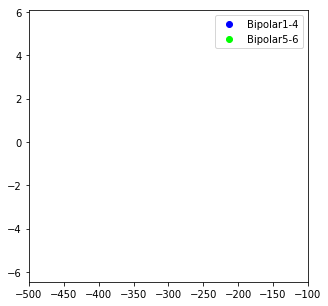

In [58]:
# Now have the legends
plt.figure(figsize=(5, 5))

cmap = plt.get_cmap("brg", 2)
label = ["Bipolar1-4", "Bipolar5-6"]
for t in np.unique(b_train):
    plt.scatter(tsne_combat[b_train[:, 0] == t, 0], tsne_combat[b_train[:, 0] == t, 1], c=cmap((t-1) / 2.), label=label[t-1])
plt.xlim((-500, -100))
plt.legend()
plt.savefig("bipolar_legend_batches.pdf", dpi=300)

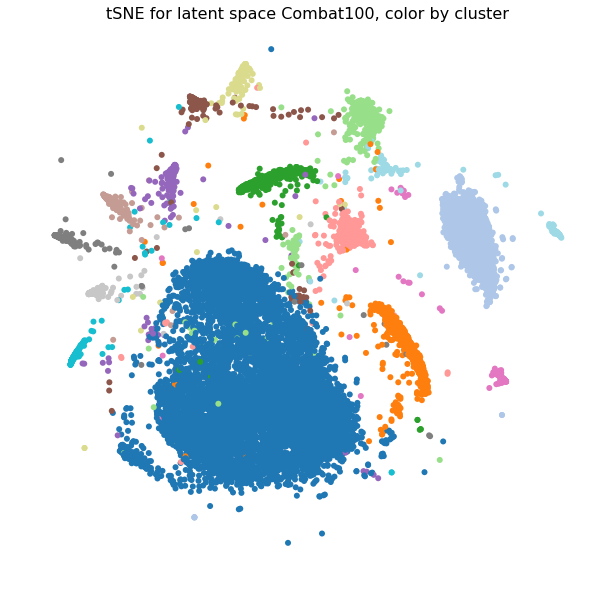

In [20]:
show_tSNE(tsne_combat, "Combat100, color by cluster", tSNE=False, labels=c_train)
plt.savefig("Combat_tSNE_bipolar_clusters.pdf", dpi=300)

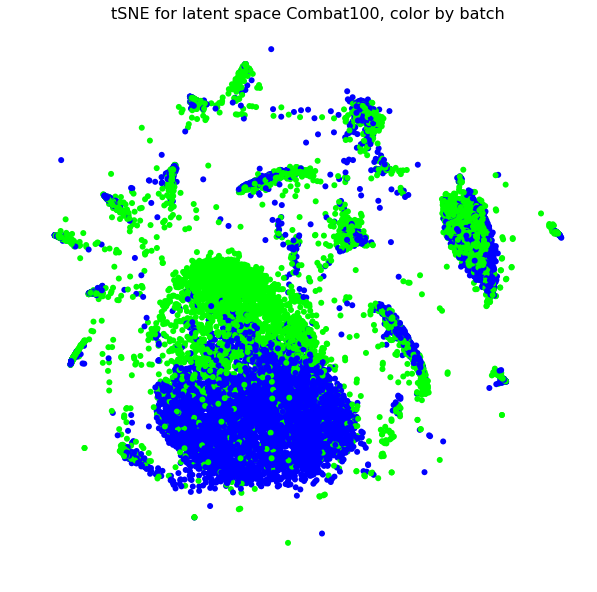

In [21]:
show_tSNE(tsne_combat, "Combat100, color by batch", tSNE=False, labels=b_train, cmap=plt.get_cmap("brg", 2))
plt.savefig("Combat_tSNE_bipolar_batch.pdf", dpi=300)

In [22]:
projection_pca = PCA(n_components=n_latent).fit_transform(np.log(1 + expression_train))
print cluster_scores(projection_pca, len(np.unique(c_train)), c_train)
print entropy_batch_mixing(projection_pca, b_train)
print silhouette_score(projection_pca, b_train)

[0.21954027735402515, 0.58685860355428821, 0.36856986097377797]
0.192647888467
0.0624201044534


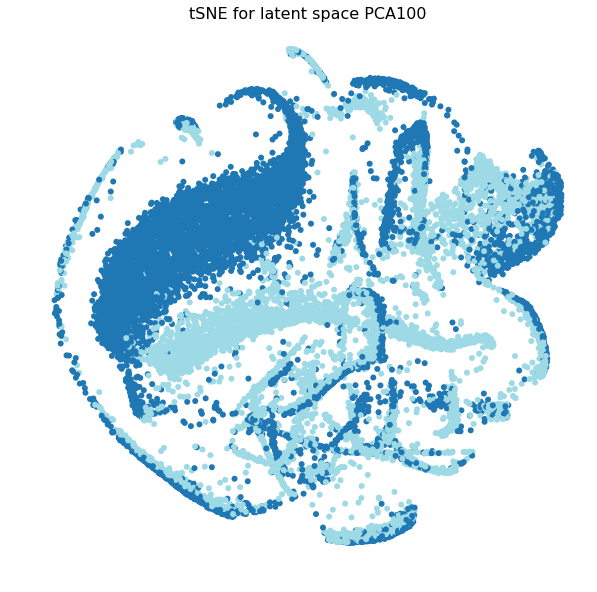

In [23]:
projection_pca = PCA(n_components=100).fit_transform(np.log(1 + expression_train))
tsne = show_tSNE(projection_pca, "PCA100", labels=b_train)

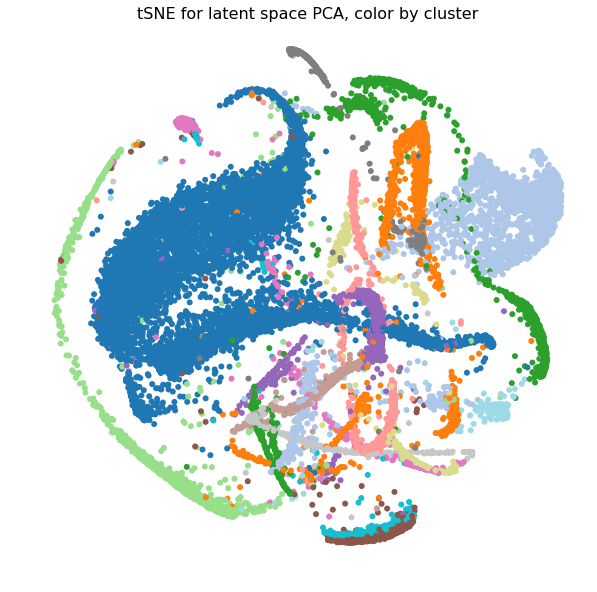

In [26]:
show_tSNE(tsne, "PCA, color by cluster", tSNE=False, labels=c_train)
plt.savefig("PCA_tSNE_bipolar_clusters.pdf", dpi=300)

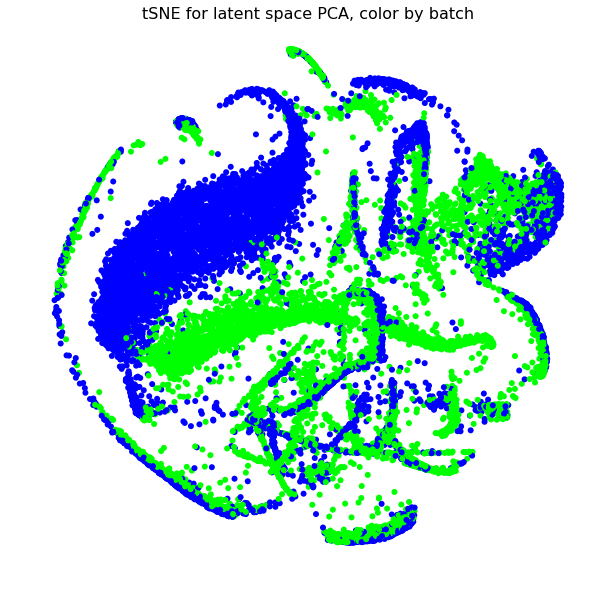

In [27]:
show_tSNE(tsne, "PCA, color by batch", tSNE=False, labels=b_train, cmap="brg")
plt.savefig("PCA_tSNE_bipolar_batch.pdf", dpi=300)

In [28]:
simlr = SIMLR(n_clusters=len(np.unique(c_train)))
%time simlr.fit_transform(expression_train)

Performing fast PCA.
Performing k-nearest neighbour search.
Computing the multiple Kernels.
Performing the iterative procedure  5  times.
Iteration:  1 
Iteration:  2 
Iteration:  3 
Iteration:  4 
Iteration:  5 
Performing Kmeans.
Performing t-SNE.
The main loop will be now performed with a maximum of 300 iterations.
Performing iteration 1.
Performing iteration 2.
Performing iteration 3.
Performing iteration 4.
Performing iteration 5.
Performing iteration 6.
Performing iteration 7.
Performing iteration 8.
Performing iteration 9.
Performing iteration 10.
Performing iteration 11.
Performing iteration 12.
Performing iteration 13.
Performing iteration 14.
Performing iteration 15.
Performing iteration 16.
Performing iteration 17.
Performing iteration 18.
Performing iteration 19.
Performing iteration 20.
Performing iteration 21.
Performing iteration 22.
Performing iteration 23.
Performing iteration 24.
Performing iteration 25.
Performing iteration 26.
Performing iteration 27.
Performing ite

SIMLR(n_clusters=15)

In [29]:
print cluster_scores(simlr.F, len(np.unique(c_train)), c_train)
print entropy_batch_mixing(simlr.F, b_train)
print silhouette_score(simlr.F, b_train)

[0.34417779654030661, 0.64755125928853896, 0.51136144259466121]
0.597048161687
0.0409665873338


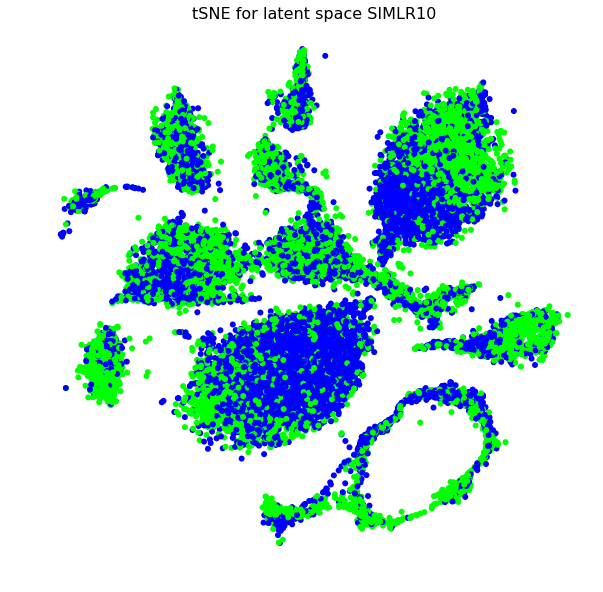

In [32]:
show_tSNE(simlr.ydata, "SIMLR10", labels=b_train, tSNE=False,  cmap="brg")
plt.savefig("SIMLR_tSNE_bipolar_batch.pdf")

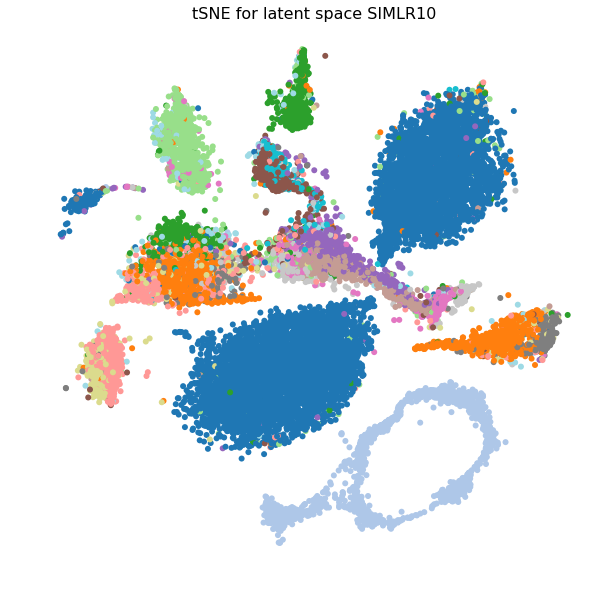

In [33]:
show_tSNE(simlr.ydata, "SIMLR10", labels=c_train, tSNE=False)
plt.savefig("SIMLR_tSNE_bipolar_clusters.pdf")

## imputation

In [31]:
X_zero, i, j, ix = dropout(X_train, 1., uniform=True)
scipy.sparse.save_npz(data_path + "imputation/X_zero.npz", scipy.sparse.coo_matrix(X_zero))
np.save(data_path + "imputation/i.npy", i)
np.save(data_path + "imputation/j.npy", j)
np.save(data_path + "imputation/ix.npy", ix)

In [9]:
X_zero, i, j, ix = \
        scipy.sparse.load_npz(data_path + "imputation/X_zero.npz").A,\
        np.load(data_path + "imputation/i.npy"), \
        np.load(data_path + "imputation/j.npy"), \
        np.load(data_path + "imputation/ix.npy")

In [10]:
mean_MAGIC = np.load(data_path + "imputation/X_zero_MAGIC.npy")
print("MAGIC", imputation_error(mean_MAGIC, X_train, X_zero, i, j, ix))

('MAGIC', 0.5378173538893567)
